In [101]:
import pandas as pd
import numpy as np

import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [373]:
# Читаем все файлы и записываем в датафреймы
assessments = pd.read_csv('assessments.csv')
courses = pd.read_csv('courses.csv')
student_assm = pd.read_csv('studentAssessment.csv')
student_reg = pd.read_csv('studentRegistration.csv')

In [374]:
# Мерджим инфо о курсах и тестах
assess = assessments.merge(courses, how = 'left', on = ['code_module', 'code_presentation'])

In [375]:
# Меджим инфо о тестах с курсами и датафрейм с данными о результатах студентов
students_testing = student_assm.merge(assess, how = 'left', on = 'id_assessment')

In [376]:
# Мерджим предыдущий датафрейм с данными о регистрациях студентов на курсы
df = students_testing.merge(student_reg, how = 'left', on = ['code_module', 'code_presentation', 'id_student'])

In [377]:
# Переименовываем колонки с инфо о семестрах, чтобы было более понятно (сейчас не совсем очевидно что такое presentation)
df = df.rename(columns={'code_presentation': 'id_semester', 'module_presentation_length': 'semester_length'})

In [378]:
df.shape

(173912, 13)

In [108]:
# Всего у нас 4 семестра, примем, что B идет раньше чем J
df.id_semester.value_counts()

2014J    52174
2013J    49018
2014B    38896
2013B    33824
Name: id_semester, dtype: int64

In [109]:
# Стоит заметить, что в итоговой таблице остались данные только для тех предметов и экзаменов,
# которые студенты сдавали, тесты без данных по сдачам в датафрейм не попали
df.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,id_semester,assessment_type,date,weight,semester_length,date_registration,date_unregistration
0,1752,11391,18,0,78.0,AAA,2013J,TMA,19.0,10.0,268,-159.0,NaN
1,1752,28400,22,0,70.0,AAA,2013J,TMA,19.0,10.0,268,-53.0,NaN
2,1752,31604,17,0,72.0,AAA,2013J,TMA,19.0,10.0,268,-52.0,NaN
3,1752,32885,26,0,69.0,AAA,2013J,TMA,19.0,10.0,268,-176.0,NaN
4,1752,38053,19,0,79.0,AAA,2013J,TMA,19.0,10.0,268,-110.0,NaN


In [110]:
# Проверка на пустые значения
df.isna().sum()

id_assessment               0
id_student                  0
date_submitted              0
is_banked                   0
score                     173
code_module                 0
id_semester                 0
assessment_type             0
date                     2865
weight                      0
semester_length             0
date_registration           7
date_unregistration    160857
dtype: int64

In [111]:
# Пустые поля для студентов НЕ отменивших регистрацию на курс заполняем нулем
# Пустые поля с инфо о результатах (баллах) за тесты заполняем нулями, предполагая что сдача засчитана как 0 баллов
# Пустые поля даты регистрации помечаем 9999 для дальнейшего анализа (вероятно, ошибки записи данных так как таких записей очень мало)
# Пустые поля с датой (дедлайном) сдачи теста на предмете помечаем как 9999. Гипотеза - это тесты без дедлайна, так будет удобнее для сравнения
df.date_unregistration = df.date_unregistration.fillna(0)
df.score = df.score.fillna(0)
df.date_registration = df.date_registration.fillna(9999)
df.date = df.date.fillna(9999)

In [112]:
# Для удобства работы с данным изменим тип для некоторых данных, где плавающая точка нам не нужна
df = df.astype({'date' : 'int64'})
df = df.astype({'score' : 'int64'})
df = df.astype({'weight' : 'int64'})
df = df.astype({'date_registration' : 'int64'})
df = df.astype({'date_unregistration' : 'int64'})

In [113]:
df.dtypes

id_assessment           int64
id_student              int64
date_submitted          int64
is_banked               int64
score                   int64
code_module            object
id_semester            object
assessment_type        object
date                    int64
weight                  int64
semester_length         int64
date_registration       int64
date_unregistration     int64
dtype: object

-------------------------------------------------------------------

 ### **I. Сколько студентов успешно сдали только один курс?**

In [114]:
# Примем за рабочий вариант, что КУРС = ПРЕДМЕТ В ОПРЕДЕЛЕННОМ СЕМЕСТРЕ
# Сдать курс - сдать экзамен (assessment_type = Exam) по предмету (code_module) на не менее 40 баллов (score).
# Сдача при этом должна пройти (date_submitted) не позже даты дедлайна (date) для тестов с дедлайнами

In [115]:
# Отсортируем данные по студентам которые сдавали экзамен и набрали больше 40 баллов включительно
df_exams_done = df.query('assessment_type == "Exam" & score >= 40 & date_submitted <= date')

In [116]:
# Логов с нулевым днем сдачи нет
df_exams_done.query('date_submitted == "0"')

,id_assessment,id_student,date_submitted,is_banked,score,code_module,id_semester,assessment_type,date,weight,semester_length,date_registration,date_unregistration


In [117]:
df_exams_done.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,id_semester,assessment_type,date,weight,semester_length,date_registration,date_unregistration
52924,24290,559706,234,0,78,CCC,2014B,Exam,9999,100,241,-22,0
52925,24290,559770,230,0,54,CCC,2014B,Exam,9999,100,241,-22,0
52926,24290,560114,230,0,64,CCC,2014B,Exam,9999,100,241,-281,0
52927,24290,560311,234,0,100,CCC,2014B,Exam,9999,100,241,-28,0
52928,24290,560494,230,0,92,CCC,2014B,Exam,9999,100,241,-46,0


In [118]:
df_exams_done.code_module.value_counts()

DDD    2703
CCC    1683
Name: code_module, dtype: int64

In [119]:
# Удалим студентов, которые сдали более одного экзамена (их id дублируется)
df_exams_done.drop_duplicates(subset = 'id_student', keep = False)

,id_assessment,id_student,date_submitted,is_banked,score,code_module,id_semester,assessment_type,date,weight,semester_length,date_registration,date_unregistration
52925,24290,559770,230,0,54,CCC,2014B,Exam,9999,100,241,-22,0
52928,24290,560494,230,0,92,CCC,2014B,Exam,9999,100,241,-46,0
52929,24290,561363,230,0,84,CCC,2014B,Exam,9999,100,241,-29,0
52930,24290,561559,230,0,42,CCC,2014B,Exam,9999,100,241,-123,0
52931,24290,561774,230,0,62,CCC,2014B,Exam,9999,100,241,-102,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95978,25368,652617,243,0,56,DDD,2014J,Exam,9999,100,262,-127,0
95980,25368,652680,243,0,91,DDD,2014J,Exam,9999,100,262,-144,0
95981,25368,652732,249,0,47,DDD,2014J,Exam,9999,100,262,-17,0
95982,25368,652965,242,0,87,DDD,2014J,Exam,9999,100,262,-142,0


Только **один** экзамен сдали 3796 студента

---------------------------------------------------------------------------------------------------------------------------

### **II. Выявить самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью.**

In [120]:
# Отфильтруем данные только об экзаменах (Exam)
df_exams = df.query('assessment_type == "Exam"')

In [121]:
df_exams.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,id_semester,assessment_type,date,weight,semester_length,date_registration,date_unregistration
52923,24290,558914,230,0,32,CCC,2014B,Exam,9999,100,241,-74,0
52924,24290,559706,234,0,78,CCC,2014B,Exam,9999,100,241,-22,0
52925,24290,559770,230,0,54,CCC,2014B,Exam,9999,100,241,-22,0
52926,24290,560114,230,0,64,CCC,2014B,Exam,9999,100,241,-281,0
52927,24290,560311,234,0,100,CCC,2014B,Exam,9999,100,241,-28,0


In [122]:
df_exams.id_student.nunique()

4633

In [123]:
# Для удобства добавим новую колонку: сдал студент экзамен или нет, исходя из критериев выведенных в пункте проекта I

In [124]:
df_exams['exam_passed'] = 0

C:\Users\AZATMI~1\AppData\Local\Temp/ipykernel_2852/2032424647.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exams['exam_passed'] = 0


In [125]:
df_exams.exam_passed = np.where((df_exams['score'] >= 40) & (df_exams['date_submitted'] <= df_exams['date']), 1, 0) 

C:\Users\AZATMI~1\AppData\Local\Temp/ipykernel_2852/780875781.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exams.exam_passed = np.where((df_exams['score'] >= 40) & (df_exams['date_submitted'] <= df_exams['date']), 1, 0)


In [126]:
# Получим кол-во успешных попыток и кол-во неудачых попыток сдачи экзамнена
df_exams.exam_passed.value_counts()

1    4386
0     573
Name: exam_passed, dtype: int64

In [127]:
# Сгруппируем по предмету и семестру и посчитаем кол-во сдач и попыток в целом
# это необязательная часть, далее мы проделаем то же самое с привязкой к коду теста
df_exams.groupby(['code_module', 'id_semester'], as_index = False)\
.agg({'exam_passed' : 'sum', 'score' : 'count'})\
.rename(columns = {'score' : 'total_attempts'})

,code_module,id_semester,exam_passed,total_attempts
0,CCC,2014B,664,747
1,CCC,2014J,1019,1168
2,DDD,2013B,501,602
3,DDD,2013J,878,968
4,DDD,2014B,482,524
5,DDD,2014J,842,950


In [128]:
# Можно сгруппировать по номеру экзамена
df_exam_completion = df_exams.groupby('id_assessment', as_index = False)\
.agg({'exam_passed' : 'sum', 'score' : 'count'})\
.rename(columns = {'score' : 'total_attempts'})

In [129]:
df_exam_completion['completion_ratio'] = (df_exam_completion['exam_passed'] / df_exam_completion['total_attempts']).round(2)

In [130]:
df_exam_completion

,id_assessment,exam_passed,total_attempts,completion_ratio
0,24290,664,747,0.89
1,24299,1019,1168,0.87
2,25340,501,602,0.83
3,25354,878,968,0.91
4,25361,482,524,0.92
5,25368,842,950,0.89


Лучшая завершаемость у экзамена под номером **25361** - МНОГО удачных сдач на общее число попыток. Это самый легкий экзамен (вероятно).
Самый тяжелый экзамен - **25340**.

Соответственно предмет DDD в семестре 2014В был самых завершаемым. Тот же предмет DDD в семестре 2013В - самым трудно завершаемым.

In [131]:
# добавим в общий датафрейм столбцы с данными по экзаменам - завершаемость и инфо о сдаче/несдаче
df_exams = pd.merge(df_exams, df_exam_completion[['id_assessment', 'completion_ratio']],on='id_assessment', how='left')

In [132]:
df = pd.merge(df, df_exams[['id_student', 'code_module', 'id_semester', 'exam_passed', 'completion_ratio']], how = 'left', on = ['id_student', 'code_module', 'id_semester'])

In [133]:
df.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,id_semester,assessment_type,date,weight,semester_length,date_registration,date_unregistration,exam_passed,completion_ratio
0,1752,11391,18,0,78,AAA,2013J,TMA,19,10,268,-159,0,NaN,NaN
1,1752,28400,22,0,70,AAA,2013J,TMA,19,10,268,-53,0,NaN,NaN
2,1752,31604,17,0,72,AAA,2013J,TMA,19,10,268,-52,0,NaN,NaN
3,1752,32885,26,0,69,AAA,2013J,TMA,19,10,268,-176,0,NaN,NaN
4,1752,38053,19,0,79,AAA,2013J,TMA,19,10,268,-110,0,NaN,NaN


In [134]:
df.exam_passed.value_counts()

1.0    34833
0.0     4738
Name: exam_passed, dtype: int64

-------------------------------------

### **III. По каждому предмету определи средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом)**

In [135]:
# Экзамен присутствует только на двух предметах. Будем сравнивать их - DDD и CCC

In [136]:
df.query('assessment_type == "Exam"').groupby('id_assessment')\
.code_module.value_counts()

id_assessment  code_module
24290          CCC             747
24299          CCC            1168
25340          DDD             602
25354          DDD             968
25361          DDD             524
25368          DDD             950
Name: code_module, dtype: int64

In [137]:
df.query('assessment_type == "Exam"').groupby('id_assessment')\
.id_semester.value_counts()

id_assessment  id_semester
24290          2014B           747
24299          2014J          1168
25340          2013B           602
25354          2013J           968
25361          2014B           524
25368          2014J           950
Name: id_semester, dtype: int64

In [138]:
# Записей где студент сдал экзамен а потом отменил регистрацию нет
df.query('date_unregistration > date_submitted & assessment_type == "Exam"')

,id_assessment,id_student,date_submitted,is_banked,score,code_module,id_semester,assessment_type,date,weight,semester_length,date_registration,date_unregistration,exam_passed,completion_ratio


In [139]:
# Оставим только тех студентов, кто зарегистрировался и не уходил с курса и сдавал экзамен.
# Сгруппируем по студентам и возьмем только максимальные даты сдачи экзамен (последние)
# На самом деле путем проверки выяснилось, что даже опуская этот шаг результата будет таким же, но стоит проверять исходя из условий задачи
df1 = df.query('date_unregistration == 0 & assessment_type == "Exam"')\
.groupby(['id_student', 'code_module', 'id_semester'], as_index = False)\
.max('date_submitted')

In [140]:
# Сгруппируем по предмету и семестру и вычислим среднее время до окончательной успешной сдачи экзамена студентом
df_avg_date = df1.groupby(['code_module', 'id_semester'], as_index = False)\
.date_submitted.mean().round(2)\
.rename(columns = {'date_submitted' : 'average_date'})

In [141]:
df_avg_date

,code_module,id_semester,average_date
0,CCC,2014B,231.62
1,CCC,2014J,244.39
2,DDD,2013B,230.18
3,DDD,2013J,239.51
4,DDD,2014B,234.94
5,DDD,2014J,242.79


In [142]:
df = pd.merge(df, df_avg_date, how = 'left', on = ['code_module', 'id_semester'])

In [143]:
# Ради интереса посмотрим дедлайн для экзаменов
df.query('date_unregistration == 0 & assessment_type == "Exam"')\
.groupby(['code_module', 'id_semester'], as_index = False)\
.date.min().round(2)

,code_module,id_semester,date
0,CCC,2014B,9999
1,CCC,2014J,9999
2,DDD,2013B,240
3,DDD,2013J,261
4,DDD,2014B,241
5,DDD,2014J,9999


Быстрее всего (в среднем) завершали экзамен по предмету **DDD** в семестре **2013B**. Это неоднозначно коррелирует с завершаемостью, так как экзамен считается наиболее сложным по метрике завершаемости. Это может быть связано с тем, что у теста наименьший дедлайн.

Дольше всего сдавали (в среднем) экзамен по предмету **ССС** в семестре **2014J**. У него нет дедлайна (могли затягивать со сдачей)

----------------------------------------------------------

### **IV. Выяви самые популярные курсы (ТОП-3) по количеству регистраций на них. А также курсы с самым большим оттоком (ТОП-3)**

In [144]:
df.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,id_semester,assessment_type,date,weight,semester_length,date_registration,date_unregistration,exam_passed,completion_ratio,average_date
0,1752,11391,18,0,78,AAA,2013J,TMA,19,10,268,-159,0,NaN,NaN,NaN
1,1752,28400,22,0,70,AAA,2013J,TMA,19,10,268,-53,0,NaN,NaN,NaN
2,1752,31604,17,0,72,AAA,2013J,TMA,19,10,268,-52,0,NaN,NaN,NaN
3,1752,32885,26,0,69,AAA,2013J,TMA,19,10,268,-176,0,NaN,NaN,NaN
4,1752,38053,19,0,79,AAA,2013J,TMA,19,10,268,-110,0,NaN,NaN,NaN


In [145]:
# 13047 логов, когда студент отменял регистрацию на предмет
df.loc[df['date_unregistration'] != 0].shape

(13047, 16)

In [146]:
# Есть логи, где отмена произошла до начала курса/семестра,
# но везде она была позже регистрации, так что предположим, что это не ошибка, а студент просто передумал 
# df.loc[df['date_unregistration'] < 0]

In [147]:
df_unregistered = df.loc[df['date_unregistration'] != 0]

In [148]:
# ТОП 3 самых частых по отменам регистраций курсов: CCC-2014J, DDD-2013B, CCC-2014B
df_unregistered.groupby(['code_module', 'id_semester'], as_index = False)\
.agg({'date_unregistration' : 'count'})\
.sort_values('date_unregistration', ascending = False).head(3)

,code_module,id_semester,date_unregistration
7,CCC,2014J,1476
8,DDD,2013B,1186
6,CCC,2014B,1054


**ТОП 3** курса с самым высоким оттоком: **CCC-2014J, DDD-2013B, CCC-2014B**
Вероятно, это связано с тем, что эти предметы имеют экзамены (условие для завершения), и при этом отличаются относительно невысокой завершаемостью и долгой сдачей. Иными словами, гипотеза в том, что они имеют сложные экзамены

In [149]:
df_passed_courses = df.loc[df['date_unregistration'] == 0]

In [150]:
df_passed_courses.groupby(['code_module', 'id_semester'], as_index = False)\
.agg({'date_registration' : 'count'})\
.sort_values('date_registration', ascending = False).head(3)

,code_module,id_semester,date_registration
18,FFF,2014J,15201
16,FFF,2013J,15193
3,BBB,2013J,13645


**ТОП 3** популярных курса, с которых при этом не уходили студенты: **FFF-2014J, FFF-2013J, BBB-2013J**

In [151]:
df_passed_courses.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,id_semester,assessment_type,date,weight,semester_length,date_registration,date_unregistration,exam_passed,completion_ratio,average_date
0,1752,11391,18,0,78,AAA,2013J,TMA,19,10,268,-159,0,NaN,NaN,NaN
1,1752,28400,22,0,70,AAA,2013J,TMA,19,10,268,-53,0,NaN,NaN,NaN
2,1752,31604,17,0,72,AAA,2013J,TMA,19,10,268,-52,0,NaN,NaN,NaN
3,1752,32885,26,0,69,AAA,2013J,TMA,19,10,268,-176,0,NaN,NaN,NaN
4,1752,38053,19,0,79,AAA,2013J,TMA,19,10,268,-110,0,NaN,NaN,NaN


--------------------------------------------------------------------------------------------

### **V.  Cеместр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов в период с начала 2013 по конец 2014**

In [152]:
df.head()
# Оценить завершаемость и сдачу курса мы сможем только по предметам ССС и DDD так как только в них студенты сдавали экзамены
# По условию сдачей курса считается сдача экзамена (строгое условие)

,id_assessment,id_student,date_submitted,is_banked,score,code_module,id_semester,assessment_type,date,weight,semester_length,date_registration,date_unregistration,exam_passed,completion_ratio,average_date
0,1752,11391,18,0,78,AAA,2013J,TMA,19,10,268,-159,0,NaN,NaN,NaN
1,1752,28400,22,0,70,AAA,2013J,TMA,19,10,268,-53,0,NaN,NaN,NaN
2,1752,31604,17,0,72,AAA,2013J,TMA,19,10,268,-52,0,NaN,NaN,NaN
3,1752,32885,26,0,69,AAA,2013J,TMA,19,10,268,-176,0,NaN,NaN,NaN
4,1752,38053,19,0,79,AAA,2013J,TMA,19,10,268,-110,0,NaN,NaN,NaN


In [153]:
df.groupby('id_semester', as_index = False)\
.agg({'completion_ratio' : 'min'})

,id_semester,completion_ratio
0,2013B,0.83
1,2013J,0.91
2,2014B,0.89
3,2014J,0.87


Семестр с самой низкой завершаемостью - **2013B**. Сложные экзамены с отосительно короткими дедлайнами.

Можно рассчитать группируя по семестру и высчитать средние показатели завершаемости, но результат будет тем же:

In [154]:
df_semester = df.query('assessment_type == "Exam"').groupby(['id_semester'], as_index = False)\
.agg({'exam_passed' : 'sum', 'score' : 'count'})\
.rename(columns = {'score' : 'total_attempts'})

In [155]:
df_semester

,id_semester,exam_passed,total_attempts
0,2013B,501.0,602
1,2013J,878.0,968
2,2014B,1146.0,1271
3,2014J,1861.0,2118


In [156]:
df_semester['completion_ratio'] = (df_semester['exam_passed'] / df_semester['total_attempts']).round(2)

-------------------------------------

In [157]:
# Рассчитаем как в задании 3 - максимальную дату сдачи экза, но группируя по семестру и студентам
df1 = df.query('date_unregistration == 0 & assessment_type == "Exam"')\
.groupby(['id_student', 'id_semester'], as_index = False)\
.max('date_submitted')

In [158]:
# Переиспользуем ранее созданный код и высчитаем среднее время сдачи, группируя по семестру
df_avg_date = df1.groupby(['id_semester'], as_index = False)\
.date_submitted.mean().round(2)\
.rename(columns = {'date_submitted' : 'avg_sem_completion'})

In [159]:
df_avg_date

,id_semester,avg_sem_completion
0,2013B,230.18
1,2013J,239.51
2,2014B,233.00
3,2014J,243.70


Самый долгий по средним срокам сдачи семестр в 2013-2014 - **2014J**. Коррелирует с тем, что в этом же семестре есть курс предмета ССС с высоким оттоком

--------------------------------------------------

### **VI.  RFM-анализ**

RFM-кластеры студентов по следующим метрикам:\
**R** - среднее время сдачи одного экзамена\
**F** - завершаемость курсов\
**M** - среднее количество баллов, получаемое за экзамен.

In [327]:
# Сделаем отдельную таблицу с экзаменами без неинтересующих нас логов
df_rfm = df.query('date_unregistration == 0 & assessment_type == "Exam"')

Посчитаем метрику М - среднее кол-во баллов студента за экзамены

In [328]:
df_avg_score = df_rfm.groupby('id_student', as_index = False)\
.agg({'score' : 'mean'}).round(2)\
.rename(columns = {'score' : 'student_avg_score'})

In [329]:
df_rfm = pd.merge(df_rfm, df_avg_score, how = 'left', on = ['id_student'])

In [330]:
# sns.displot(df_rfm.student_avg_score)

In [331]:
# Можем выделить в отдельную категорию тех, кто в среднем набрал меньше 40 (граничное условие для сдачи экза)
# Выделять еще две категории не вижу особого смысла так как для нас нет существенной разница сдал студент в среднем на 60 или на 80 или на 90
# Поэтому выделим еще одну, выше 40 баллов

In [332]:
# ddf = df_rfm[df_rfm['student_avg_score'] > 40]

In [333]:
# sns.displot(ddf.student_avg_score)

In [334]:
# Рассчитаем метрику М, поделим средние баллы студентов на 3 сегмента
df_rfm['M_category'] = pd.cut(df_rfm.student_avg_score, bins = [0, 40, 100], labels = [1, 2])

In [335]:
df_rfm

,id_assessment,id_student,date_submitted,is_banked,score,code_module,id_semester,assessment_type,date,weight,semester_length,date_registration,date_unregistration,exam_passed,completion_ratio,average_date,student_avg_score,M_category
0,24290,558914,230,0,32,CCC,2014B,Exam,9999,100,241,-74,0,0.0,0.89,231.62,34.0,1
1,24290,559706,234,0,78,CCC,2014B,Exam,9999,100,241,-22,0,1.0,0.89,231.62,75.5,2
2,24290,559770,230,0,54,CCC,2014B,Exam,9999,100,241,-22,0,1.0,0.89,231.62,54.0,2
3,24290,560114,230,0,64,CCC,2014B,Exam,9999,100,241,-281,0,1.0,0.89,231.62,57.5,2
4,24290,560311,234,0,100,CCC,2014B,Exam,9999,100,241,-28,0,1.0,0.89,231.62,86.5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4953,25368,652680,243,0,91,DDD,2014J,Exam,9999,100,262,-144,0,1.0,0.89,242.79,91.0,2
4954,25368,652732,249,0,47,DDD,2014J,Exam,9999,100,262,-17,0,1.0,0.89,242.79,47.0,2
4955,25368,652965,242,0,87,DDD,2014J,Exam,9999,100,262,-142,0,1.0,0.89,242.79,87.0,2
4956,25368,653051,242,0,27,DDD,2014J,Exam,9999,100,262,-60,0,0.0,0.89,242.79,27.0,1


In [336]:
df_rfm['exam_passed'] = df_rfm['exam_passed'].astype('int64')

Посчитаем метрику F - завершаемость экзаменов у студентов

In [337]:
df_f = df_rfm.groupby('id_student', as_index = False)\
.agg({'score' : 'count', 'exam_passed' : 'sum'})

In [338]:
df_f['completion_ratio_student'] = df_f['exam_passed'] / df_f['score']

In [339]:
# Три сегмента
df_f.completion_ratio_student.value_counts()

1.0    4063
0.0     541
0.5      28
Name: completion_ratio_student, dtype: int64

In [340]:
# Здесь выделение на 3 сегмента очевиднее - те у кого 0 (не сдали вообще ни одного), те у кого 0,5 (сдали не с первого раза) и те кто сдал с первого раза (соотношение равно 1)

In [341]:
df_f

,id_student,score,exam_passed,completion_ratio_student
0,23698,1,1,1.0
1,24213,1,1,1.0
2,27116,1,1,1.0
3,28046,1,1,1.0
4,28787,1,1,1.0
...,...,...,...,...
4627,2694886,1,1,1.0
4628,2694933,1,1,1.0
4629,2695608,1,1,1.0
4630,2697181,1,1,1.0


In [342]:
# Рассчитаем метрику F, выделим 3 сегмента для студентов
df_f['F_category'] = pd.cut(df_f.completion_ratio_student, bins = [-1, 0, 0.5, 1], labels = [1, 2, 3])

In [343]:
df_f.drop(columns = ['score', 'exam_passed', 'completion_ratio_student'], inplace = True)

In [344]:
# Смерджим с основной рабчей таблицей для анализа
df_rfm = pd.merge(df_rfm, df_f, how = 'left', on = ['id_student'])

In [345]:
df_rfm.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,id_semester,assessment_type,date,weight,semester_length,date_registration,date_unregistration,exam_passed,completion_ratio,average_date,student_avg_score,M_category,F_category
0,24290,558914,230,0,32,CCC,2014B,Exam,9999,100,241,-74,0,0,0.89,231.62,34.0,1,1
1,24290,559706,234,0,78,CCC,2014B,Exam,9999,100,241,-22,0,1,0.89,231.62,75.5,2,3
2,24290,559770,230,0,54,CCC,2014B,Exam,9999,100,241,-22,0,1,0.89,231.62,54.0,2,3
3,24290,560114,230,0,64,CCC,2014B,Exam,9999,100,241,-281,0,1,0.89,231.62,57.5,2,3
4,24290,560311,234,0,100,CCC,2014B,Exam,9999,100,241,-28,0,1,0.89,231.62,86.5,2,3


Посчитаем метрику R - среднее время сдачи одного экзамена

In [346]:
df_r = df_rfm.groupby('id_student', as_index = False)\
.agg({'date_submitted' : 'mean'})\
.rename(columns = {'date_submitted' : 'avg_date_student'})

In [347]:
np.median(df_r.avg_date_student)

241.0

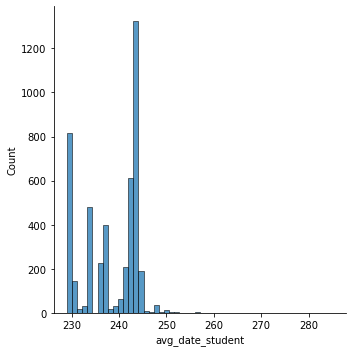

In [348]:
sns.displot(df_r.avg_date_student)

In [349]:
df_r

,id_student,avg_date_student
0,23698,243.0
1,24213,236.0
2,27116,243.0
3,28046,237.0
4,28787,243.0
...,...,...
4627,2694886,236.0
4628,2694933,230.0
4629,2695608,237.0
4630,2697181,230.0


In [350]:
df_r['R_category'] = pd.cut(df_r.avg_date_student, bins = [200, 241, 300], labels = [1, 2])

In [351]:
df_r.R_category.value_counts()

1    2425
2    2207
Name: R_category, dtype: int64

In [352]:
df_r.drop(columns = ['avg_date_student'], inplace = True)

In [353]:
# Смерджим с основной рабчей таблицей для анализа
df_rfm = pd.merge(df_rfm, df_r, how = 'left', on = ['id_student'])

In [354]:
df_rfm

,id_assessment,id_student,date_submitted,is_banked,score,code_module,id_semester,assessment_type,date,weight,semester_length,date_registration,date_unregistration,exam_passed,completion_ratio,average_date,student_avg_score,M_category,F_category,R_category
0,24290,558914,230,0,32,CCC,2014B,Exam,9999,100,241,-74,0,0,0.89,231.62,34.0,1,1,1
1,24290,559706,234,0,78,CCC,2014B,Exam,9999,100,241,-22,0,1,0.89,231.62,75.5,2,3,1
2,24290,559770,230,0,54,CCC,2014B,Exam,9999,100,241,-22,0,1,0.89,231.62,54.0,2,3,1
3,24290,560114,230,0,64,CCC,2014B,Exam,9999,100,241,-281,0,1,0.89,231.62,57.5,2,3,1
4,24290,560311,234,0,100,CCC,2014B,Exam,9999,100,241,-28,0,1,0.89,231.62,86.5,2,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4953,25368,652680,243,0,91,DDD,2014J,Exam,9999,100,262,-144,0,1,0.89,242.79,91.0,2,3,2
4954,25368,652732,249,0,47,DDD,2014J,Exam,9999,100,262,-17,0,1,0.89,242.79,47.0,2,3,2
4955,25368,652965,242,0,87,DDD,2014J,Exam,9999,100,262,-142,0,1,0.89,242.79,87.0,2,3,2
4956,25368,653051,242,0,27,DDD,2014J,Exam,9999,100,262,-60,0,0,0.89,242.79,27.0,1,1,2


In [355]:
df_rfm.columns

Index(['id_assessment', 'id_student', 'date_submitted', 'is_banked', 'score',
       'code_module', 'id_semester', 'assessment_type', 'date', 'weight',
       'semester_length', 'date_registration', 'date_unregistration',
       'exam_passed', 'completion_ratio', 'average_date', 'student_avg_score',
       'M_category', 'F_category', 'R_category'],
      dtype='object')

In [356]:
df_rfm.drop(columns = ['id_assessment', 'is_banked', 'score',
       'code_module', 'id_semester', 'assessment_type', 'date', 'weight',
       'semester_length', 'date_registration', 'date_unregistration',
       'exam_passed', 'completion_ratio', 'average_date'], inplace = True)

In [361]:
df_rfm = df_rfm.astype({'M_category': 'object', 'R_category': 'string', 'F_category': 'string'})
df_rfm = df_rfm.astype({'M_category': 'string'})

In [321]:
df_rfm.drop_duplicates(subset = 'id_student', inplace = True)

In [362]:
df_rfm.dtypes

id_student             int64
date_submitted         int64
student_avg_score    float64
M_category            string
F_category            string
R_category            string
dtype: object

In [364]:
df_rfm['RFM_cluster'] = df_rfm['R_category'] + df_rfm['F_category'] + df_rfm['M_category'] 

In [365]:
df_rfm

,id_student,date_submitted,student_avg_score,M_category,F_category,R_category,RFM_cluster
0,558914,230,34.0,1,1,1,111
1,559706,234,75.5,2,3,1,132
2,559770,230,54.0,2,3,1,132
3,560114,230,57.5,2,3,1,132
4,560311,234,86.5,2,3,1,132
...,...,...,...,...,...,...,...
4953,652680,243,91.0,2,3,2,232
4954,652732,249,47.0,2,3,2,232
4955,652965,242,87.0,2,3,2,232
4956,653051,242,27.0,1,1,2,211


In [366]:
data = df_rfm.groupby('RFM_cluster', as_index = False)\
.agg({'id_student' : 'count'})\
.rename(columns = {'id_student' : 'count'})\
.sort_values(by = 'count')

In [367]:
data

,RFM_cluster,count
8,221,2
1,112,3
7,212,3
9,222,6
2,121,12
3,122,36
10,231,43
4,131,58
6,211,265
0,111,270


<AxesSubplot:xlabel='RFM_cluster', ylabel='count'>

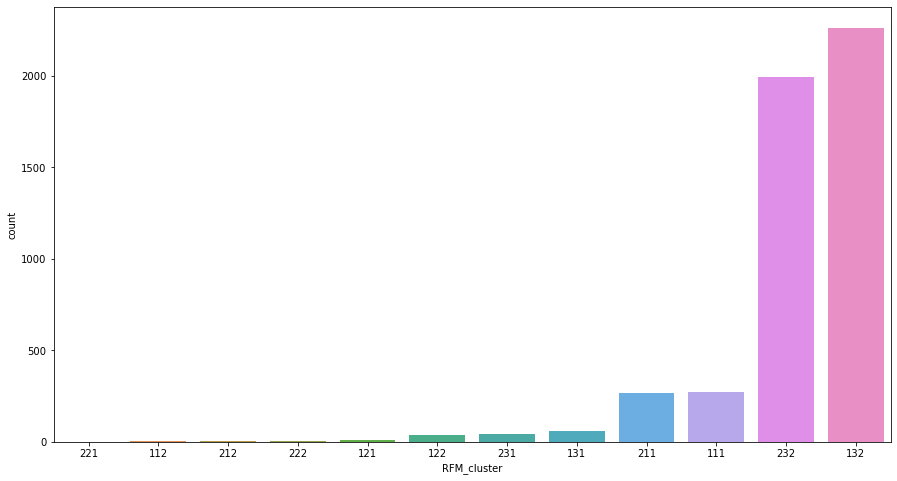

In [368]:
plt.figure(figsize=(15,8))
sns.barplot(x="RFM_cluster", y="count", data=data)

Больше всего студентов определены к кластеру 132 - средняя время сдачи экзамена с первой попытки с наибольшим количеством баллов

В топе два кластера с студентами сдавшими экзамен с первой попытки - таких большинство
Логично, что они же в среднем набрали больше 40 баллов

Текущий анализ является не исчерпывающим, так как мы упускали из анализа другие тесты и информацию по ним

Также разбиение по сегментам в RFM-анализе можно проделать, разделив данные на равные части, но в сущности это не дает нам каких-то ответов при интерпертации результатов.